
# Lets building a CNN with keras

With this training we are mean't to create CNN and make images classes, train a model with tensorflow and then predict a new image with our "intelligent" model.
It took so long us to understand how CNN works in code-side, so here we have trained and tried few things from around the net. 

To have this notebook work we'll need to:
- Put the notebook and training images in a separate folders


## Check the input directories

In [1]:
import os
print(os.listdir('../retinopathy-dataset-master'))

['images', 'newTrainLabels.csv', 'nosymptoms', 'README.md', 'retinopathy_solution.csv', 'symptoms']


# import pandas and test_print the labels csv file

In [2]:

import pandas as pd
df = pd.read_csv(r'../retinopathy-dataset-master/newTrainLabels.csv')
df.head()

,image,level,MB
0,10_left,0,0.146893
1,10_right,0,0.134647
2,13_left,0,0.179653
3,13_right,0,0.173361
4,15_left,1,0.129906


# Lets try to display 1 eye image
We will read image and display it with IPython.. wich is quite unknove territory to us. we just tried here something new here :S

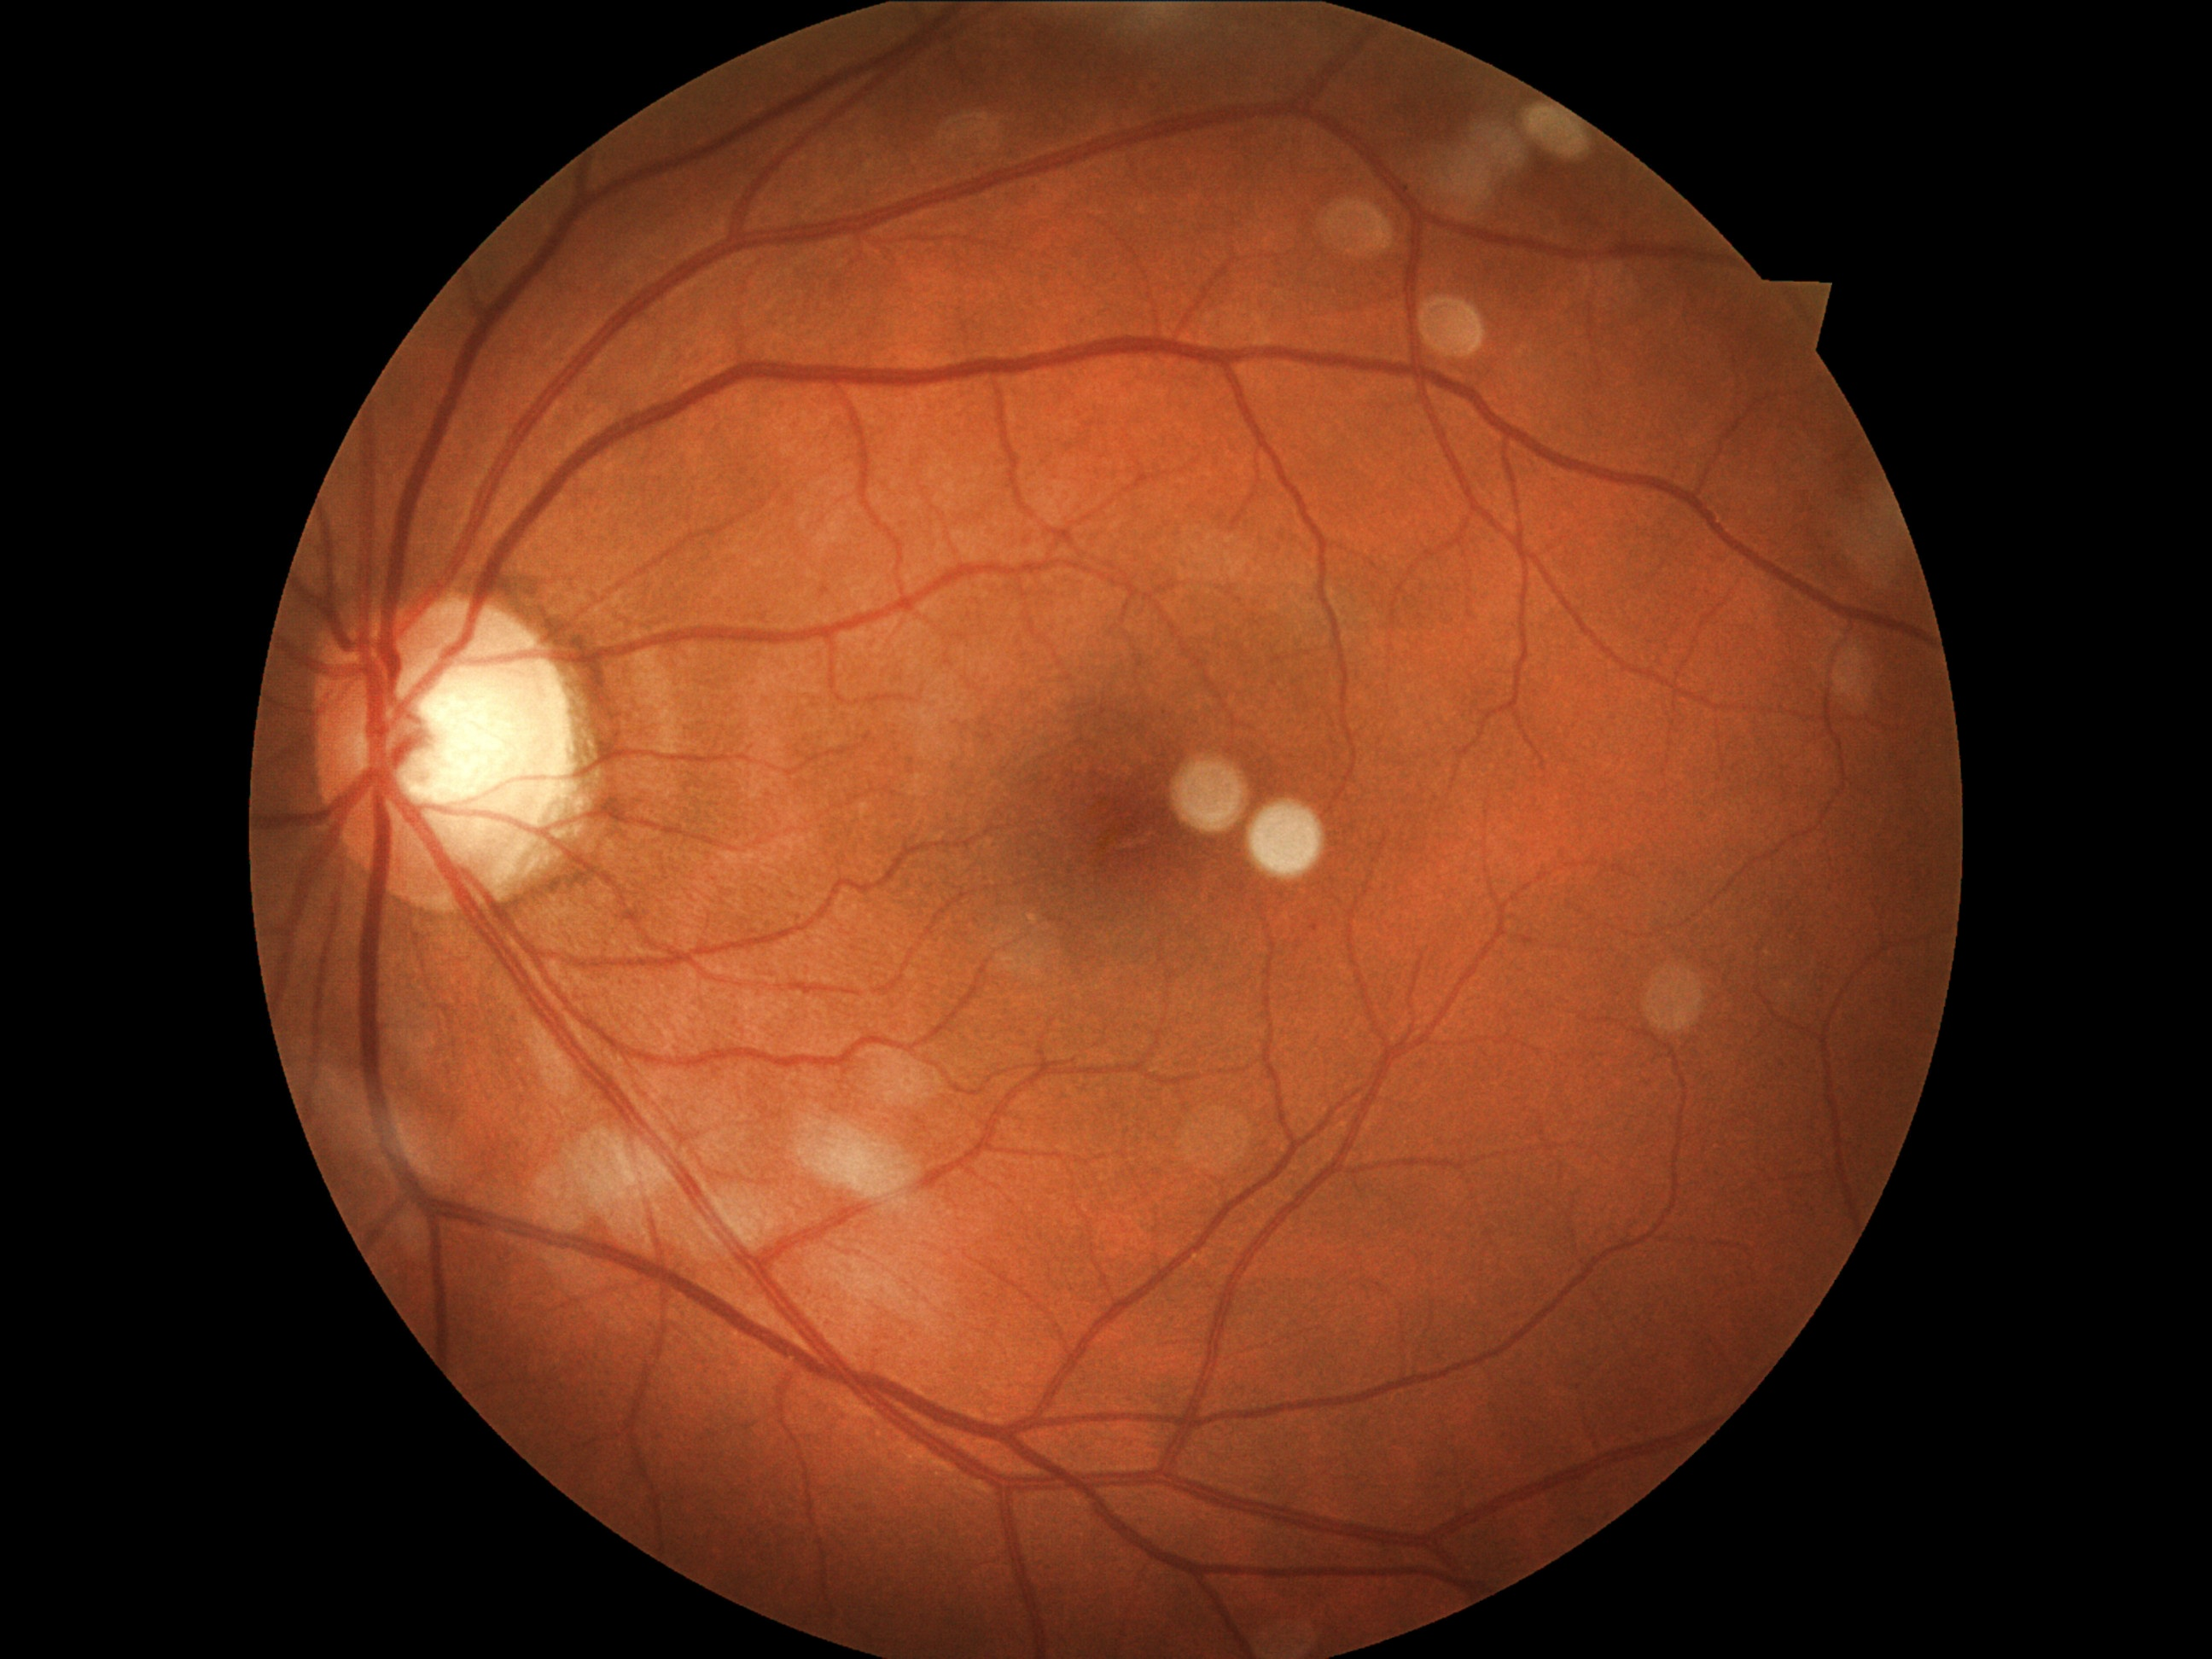

In [3]:
img_folder = '../../retinopathy-dataset-master/images'

from IPython.display import Image
Image("14664_left.jpeg")

# Next cell contains all the references to libraries that are needed to train a convolutional neural network

In [4]:

from __future__ import print_function, division

import numpy as np
import random
import os
import glob
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

from scipy.misc import imresize, imsave


from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle

from PIL import Image, ImageChops, ImageOps

import matplotlib.pyplot as plt

from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense


Using TensorFlow backend.


# Lets check if we can find the data correctly
Just to make sure

In [5]:
# Check the traindata
train_dir = "../retinopathy-dataset-master/images/"
traindata_file = train_dir + "newTrainLabels.csv"
df = pd.read_csv(traindata_file)
print(df[:20])
print(" ")

# Check if we can find the images
train_dir2 = "../retinopathy-dataset-master/images/original-images/"
f = os.listdir(train_dir)
print(f[:10])

       image  level        MB
0    10_left      0  0.146893
1   10_right      0  0.134647
2    13_left      0  0.179653
3   13_right      0  0.173361
4    15_left      1  0.129906
5   15_right      2  0.138600
6    16_left      4  0.151041
7   16_right      4  0.153951
8    17_left      0  0.169070
9   17_right      1  0.174882
10   19_left      0  0.134011
11  19_right      0  0.140882
12   20_left      0  0.149638
13  20_right      0  0.153785
14   21_left      0  0.137857
15  21_right      0  0.151753
16   22_left      0  0.124042
17  22_right      0  0.123395
18   23_left      0  0.149592
19  23_right      0  0.142346
 
['14664_left.jpeg', 'newimages', 'newTrainLabels.csv', 'nosymptoms', 'original-images', 'prepareimages', 'symptoms', 'test', 'train']


# Importing the Keras libraries and packages
- Convolution
- Pooling
- layers
- etc.

In [6]:

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# Initialising the CNN
classifier = Sequential()

# Convolution
# 32 feature detectors with a size of 3x3
# input-image's format to be 64x64 with 3 channels
classifier.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation="relu"))

# Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(activation="relu", units=128))
classifier.add(Dense(activation="sigmoid", units=1))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# use ImageDataGenerator to preprocess the data
from keras.preprocessing.image import ImageDataGenerator

# Generating data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

# Print model
classifier.summary()


# -------------------------------------------------------------------------------------------------------------------

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total para

Notes on how to set the number of epochs, steps per epoch and validation size:
 https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network

# prepare training- and test-datas

In [7]:
# ---------------------------------------------------------------------------------------------------------------------------

training_data = train_datagen.flow_from_dataframe(
                                                directory = "../retinopathy-dataset-master/images/train",
                                                dataframe = df,
                                                target_size = (64, 64),
                                                batch_size = 32,
                                                x_col = "image", 
                                                y_col = "level",
                                                has_ext = False,
                                                class_mode = 'binary')


test_data = test_datagen.flow_from_dataframe(
                                                dataframe = df,
                                                directory = "../retinopathy-dataset-master/images/test",
                                                target_size = (64, 64),
                                                batch_size = 32,
                                                x_col = "image", 
                                                y_col = "level",
                                                has_ext = False,
                                                class_mode = 'binary')


Found 551 images belonging to 5 classes.
Found 1621 images belonging to 5 classes.


# Finally start computation
To improve the model accuracy you can increase the number of steps_per_epoch to e.g. 8000 or higher... it takes werry long 
with high numbers of steps. Here we used 50, so that it would't take too long to process.


In [8]:
# save clasifier model
from time import time, localtime, strftime
# Testing with localtime and strftime
print(localtime())
print(strftime('%Y-%m-%d-%H%M%S', localtime()))

model_case2 = strftime('Case2-%Y-%m-%d-%H%M%S.h5', localtime())
classifier.save(model_case2)
print('')
print('Model saved to file:', model_case2)
print('')

# validation steps 15
# this parametters allow for the model to optimize
E = 1
t1 = time()
classifier.fit_generator(training_data,
                         steps_per_epoch = (50 / 32),
                         epochs = Ep,
                         validation_data = test_data,
                         validation_steps = 15)
t2 = time()
# Print the total elapsed time and average time per epoch in format (hh:mm:ss)
t_total = strftime('%H:%M:%S', localtime(t2 - t1))
t_per_e = strftime('%H:%M:%S', localtime((t2 - t1)/Ep))
print('Total elapsed time for {:d} epochs: {:s}'.format(Ep, t_total))
print('Average time per epoch:             {:s}'.format(t_per_e))

time.struct_time(tm_year=2019, tm_mon=3, tm_mday=3, tm_hour=23, tm_min=35, tm_sec=50, tm_wday=6, tm_yday=62, tm_isdst=0)
2019-03-03-233550

Model saved to file: Case2-2019-03-03-233550.h5

Epoch 1/1
2/1 [======================================] - 38s 19s/step - loss: 0.6224 - acc: 0.0625 - val_loss: 1.1566 - val_acc: 0.0792
Total elapsed time for 1 epochs: 02:00:38
Average time per epoch:             02:00:38


# prepare training- and test-datas for prediction algoritm
Train-directory has ~20% of orginal images and test-directory haves ~80% og orginal images, so that the 

In [9]:

# prepare training data
training_data2 = train_datagen.flow_from_directory("../retinopathy-dataset-master/images/prepareimages/train/",
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

# prepare test data
test_data2 = test_datagen.flow_from_directory("../retinopathy-dataset-master/images/prepareimages/test/",
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')


Found 647 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [10]:
# THIS IS FOR IMAGE PREDICTION
from time import time, localtime, strftime
E = 10
t1 = time()
S = classifier.fit_generator(training_data2,
                         steps_per_epoch = (50 / 32),
                         epochs = E,
                         validation_data = test_data,
                         validation_steps = 10)

# Print the total elapsed time and average time per epoch in format (hh:mm:ss)
t2 = time()
elapsed_time = (t2 - t1)
t_total = strftime('%H:%M:%S', localtime(t2 - t1))
t_per_e = strftime('%H:%M:%S', localtime((t2 - t1)/E))
print('Total elapsed time for {:d} epochs: {:s}'.format(E, t_total))
print('Average time per epoch:             {:s}'.format(t_per_e))

Epoch 1/10
2/1 [======================================] - 26s 13s/step - loss: 1.1339 - acc: 0.2969 - val_loss: 0.6867 - val_acc: 0.7625
Epoch 2/10
2/1 [======================================] - 25s 13s/step - loss: 0.5772 - acc: 0.7344 - val_loss: 0.8110 - val_acc: 0.7281
Epoch 3/10
2/1 [======================================] - 25s 12s/step - loss: 0.5725 - acc: 0.7500 - val_loss: 0.8776 - val_acc: 0.7438
Epoch 4/10
2/1 [======================================] - 25s 12s/step - loss: 0.5811 - acc: 0.7031 - val_loss: 0.8796 - val_acc: 0.7379
Epoch 5/10
2/1 [======================================] - 25s 13s/step - loss: 0.4869 - acc: 0.7969 - val_loss: 0.8056 - val_acc: 0.7562
Epoch 6/10
2/1 [======================================] - 25s 13s/step - loss: 0.5390 - acc: 0.7500 - val_loss: 0.7553 - val_acc: 0.7500
Epoch 7/10
2/1 [======================================] - 25s 12s/step - loss: 0.4730 - acc: 0.7969 - val_loss: 0.8665 - val_acc: 0.7281
Epoch 8/10
2/1 [=========================

# Lets try to plot results

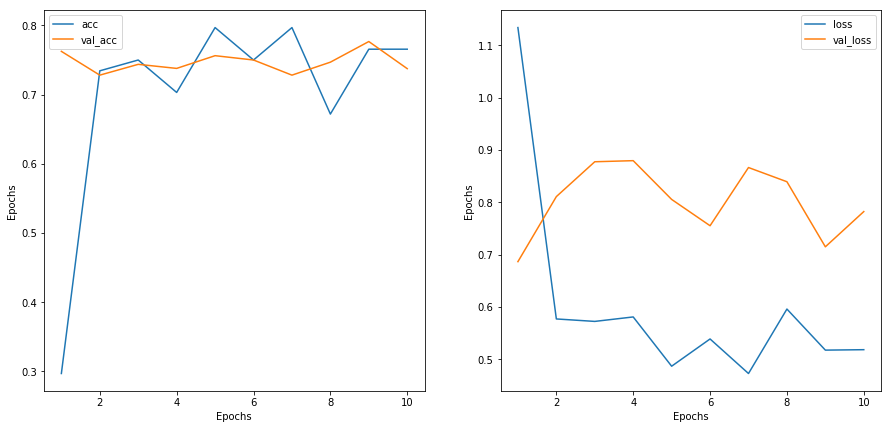

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(E) + 1.0

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,7))

def plotter(ax, epochs, S, variable):
    ax.plot(epochs, S.history[variable], label = variable)
    ax.plot(epochs, S.history['val_' + variable], label = 'val_'+variable)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Epochs')
    ax.legend()

plotter(ax1, epochs, S, 'acc')
plotter(ax2, epochs, S, 'loss')
plt.show()

# Last step's
Test other images for symptons by comparing it to trained.
On this case it would need huge size data, to get propper accuracy for prediction to be accurate.

In [34]:
from IPython.display import Image
Image("15027_right.jpeg")

# to make predictions
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('15027_right.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)

# training_set.class_indices
if result[0][0] in range(0, 1):
    prediction = 'nosymptons'
elif result[0][0] in range(1, 2):
    prediction = "symptoms lvl1"
elif result[0][0] in range(2, 3):
    predict = "symptons lvl2"
else:
    prediction = 'symptons lvl3'
    
print(result)
print(prediction)

[[0.]]
nosymptons


We were no quite sure was this working as it should, cause some times, it gave for result some float number , thats why there is those elif functions.

 ----------------------------------------------------------------------------------------------------------------------------

# Conclution
Case2 showed us how to train and validate different models and how to read and understand the whole. 
We allso learn so much more about making and understanding neural networks. 
Allso Wille learned that it's so much easier to teach NN with .csv-file that has solution-data, that trying to figure out, how 1 could learn just from the pictures.